In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount='True')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import math
import copy
import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

df = pd.read_csv('/content/drive/MyDrive/dataset_mood_smartphone.csv')  

df = df.drop(['Unnamed: 0'], axis=1)


Mounted at /content/drive


In [ ]:
df2 = copy.deepcopy(df)
df2['time'] = pd.to_datetime(df2['time'])
df2['night'] = (df2.time.dt.hour >= 1) & (df2.time.dt.hour < 6)
df2['night'].replace({False: 0, True: 1}, inplace=True)
df2['time']= pd.to_datetime(df2['time']).dt.date
df2 = df2.pivot_table(index=['id', 'time'],  values=('night'), aggfunc=np.mean)
df2['night'] = (df2['night']>0).replace({False: 0, True: 1})


In [ ]:
df3=copy.deepcopy(df)
df3['time']= pd.to_datetime(df3['time']).dt.date
df3.min(axis=0)
df3.id.unique()
df3 = df3.pivot_table(index=['id', 'time'], columns=('variable'), values=('value'), aggfunc=np.sum)
# df3['night'] = df2['night']

In [ ]:
df4 = copy.deepcopy(df)
df4['time']= pd.to_datetime(df4['time']).dt.date

# df = df.loc[df['screen'] > 1]
df4 = df4.pivot_table(index=['id', 'time'], columns='variable', values='value', aggfunc=np.mean)

# print(df4.shape)
# df4['mood'] = df4['mood'].interpolate(limit=1)
# df4.dropna(subset=['mood'], inplace=True)
# print(df4.shape)

df5=copy.deepcopy(df3)
df5['av_mood'] = df4['mood']
df5['circumplex.arousal'] = df4['circumplex.arousal']
df5['circumplex.valence'] = df4['circumplex.valence']
#of interpoleren
# df5['mood'] = df5['mood'].interpolate(limit=1)
df5.dropna(subset=['mood'], inplace=True)
df5.fillna(0, inplace=True)
df5

variable            activity  appCat.builtin  ...  sms   av_mood
id      time                                  ...               
AS14.01 2014-02-26  0.000000           0.000  ...  2.0  6.250000
        2014-02-27  0.000000           0.000  ...  0.0  6.333333
        2014-03-21  3.083152        3139.218  ...  0.0  6.200000
        2014-03-22  3.790084         731.429  ...  1.0  6.400000
        2014-03-23  2.141117        1286.246  ...  0.0  6.800000
...                      ...             ...  ...  ...       ...
AS14.33 2014-05-27  0.304902         726.391  ...  2.0  6.200000
        2014-05-28  2.479228        2551.046  ...  1.0  8.200000
        2014-05-29  4.064507         400.034  ...  1.0  7.000000
        2014-05-30  4.050925        3044.030  ...  0.0  6.800000
        2014-05-31  0.000000           0.000  ...  0.0  7.000000

[1268 rows x 20 columns]

In [ ]:
df6 = copy.deepcopy(df5)
df6.reset_index(level='id', drop=False, inplace=True)


df6.index = pd.to_datetime(df6.index)
colls = ['activity', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'call', 'circumplex.arousal', 'circumplex.valence', 'av_mood', 'screen', 'sms']
# colls = ['activity', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'call', 'circumplex.arousal', 'circumplex.valence', 'av_mood', 'screen', 'sms']
# colls = ['activity', 'appCat.builtin', 'appCat.communication', 'appCat.other', 'appCat.social', 'call', 'circumplex.arousal', 'circumplex.valence', 'av_mood', 'screen', 'sms']
# colls = ['activity', 'appCat.builtin', 'appCat.communication', 'screen','appCat.entertainment','appCat.other', 'appCat.social', 'appCat.travel', 'call', 'circumplex.arousal', 'circumplex.valence', 'av_mood', 'sms']



# colls = ['activity','call', 'circumplex.arousal', 'circumplex.valence', 'mood', 'screen', 'sms']
# colls = ['activity','call', 'circumplex.arousal', 'circumplex.valence', 'av_mood', 'screen','night', 'sms']
# colls = ['activity','call', 'circumplex.arousal', 'circumplex.valence', 'av_mood','night', 'sms']

# df6 = df6.groupby('id')[colls].rolling('6D', min_periods=5, closed='both').mean()
# df6['mood_train'] = df6['av_mood']
# df6['av_mood'] = df4['mood']

# colls.append('mood_train')
# colls.remove('av_mood')
df6

variable,id,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms,av_mood
time,,,,,,,,,,,,,,,,,,,,,
2014-02-26,AS14.01,0.000000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,-0.250000,0.750000,25.0,0.000000,2.0,6.250000
2014-02-27,AS14.01,0.000000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000000,0.333333,19.0,0.000000,0.0,6.333333
2014-03-21,AS14.01,3.083152,3139.218,6280.890,1007.456,49.544,0.0,172.206,239.751,4508.500,915.445,0.000,598.754,0.000,6.0,0.200000,0.200000,31.0,17978.907000,0.0,6.200000
2014-03-22,AS14.01,3.790084,731.429,4962.918,93.324,21.076,0.0,0.000,98.143,439.632,37.305,0.000,117.621,0.000,3.0,0.600000,0.500000,32.0,6142.161000,1.0,6.400000
2014-03-23,AS14.01,2.141117,1286.246,5237.319,94.346,43.403,0.0,0.000,72.823,900.839,0.000,0.000,30.086,30.386,0.0,0.200000,0.800000,34.0,6773.832001,0.0,6.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-05-27,AS14.33,0.304902,726.391,2078.403,124.694,0.000,0.0,0.000,142.686,2010.364,0.000,0.000,56.173,0.000,1.0,-0.600000,0.400000,31.0,4089.879001,2.0,6.200000
2014-05-28,AS14.33,2.479228,2551.046,1936.415,614.706,0.000,0.0,357.909,529.946,5361.211,0.000,0.000,30.666,0.000,10.0,0.000000,1.200000,41.0,14320.867998,1.0,8.200000
2014-05-29,AS14.33,4.064507,400.034,435.105,136.738,0.000,0.0,0.000,29.202,1789.922,0.939,0.000,3.199,0.000,5.0,-1.333333,1.000000,21.0,3569.341000,1.0,7.000000


In [ ]:
MLP_df = copy.deepcopy(df6)
MLP_df['av_mood'] = MLP_df.groupby('id')['av_mood'].shift(-1)
MLP_df['circumplex.arousal'] += 4
MLP_df['circumplex.valence'] += 4
MLP_df = MLP_df.reset_index(drop=True).dropna()



# print(MLP_df.drop(columns='id'))
colls.remove('av_mood')
# MLP_df.drop(columns='id', inplace=True)
from scipy import stats
# MLP_df = MLP_df[(np.abs(stats.zscore(MLP_df)) < 3).all(axis=1)]
print(MLP_df.shape)
print(colls)


(1241, 21)
['activity', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'call', 'circumplex.arousal', 'circumplex.valence', 'screen', 'sms']


In [ ]:

# print(df6.head(50))
# colls.append('night')
# print(MLP_df.head(50))
#Make array
X = np.array(MLP_df[colls])
y = np.array(MLP_df['av_mood'], dtype=float)

#normalise
X_n = X-X.min(axis=0) / X.max(axis=0)-X.min(axis=0)
# X_n = X/ X.mean(axis=0)
# y_n = y / y.max(axis=0)

# print(X_n.shape)

#LDA, reduce dimensions
# X_n = PCA(n_components=5).fit_transform(X_n)
# X_n_reduced = LDA_transform.transform(X_n)

# print(X_n.shape)
# Split
X_train, X_test, y_train, y_test = train_test_split(X_n, y)


# regr = MLPRegressor( max_iter=1000, hidden_layer_sizes=(32)).fit(X_train, y_train)
# regr = RandomForestRegressor(n_estimators=100).fit(X_train, y_train)
# regr = LinearSVR(max_iter=100000).fit(X_train, y_train)
# regr = LinearRegression().fit(X_train, y_train)
# regr = KNeighborsRegressor(n_neighbors=10).fit(X_train, y_train)

# print(regr.predict(X_test[:20]), y_test[:20])

test_pred = regr.predict(X_test)


print('MSE Loss = ' , ((test_pred - y_test)**2).mean())

print('Sklearn score = ', regr.score(X_test, y_test))

from sklearn.model_selection import cross_val_score
scores = cross_val_score(regr, X, y, cv=5, scoring='neg_mean_squared_error')
scores.mean()

MSE Loss =  0.5212970703822793
Sklearn score =  0.05131194903439228


-0.6092181594838133

In [ ]:
sorted([i for i in zip(regr.feature_importances_,[i for i in MLP_df[colls].columns])],key= lambda x: x[0],reverse=True)

[(0.11419568209445165, 'circumplex.valence'),
 (0.09676328158863975, 'activity'),
 (0.09243862368684853, 'appCat.entertainment'),
 (0.08585376165036528, 'appCat.other'),
 (0.08583988408586356, 'circumplex.arousal'),
 (0.08325412592010709, 'appCat.communication'),
 (0.073747729070692, 'screen'),
 (0.07063594172958114, 'appCat.social'),
 (0.06954482311058414, 'appCat.builtin'),
 (0.03903360516640631, 'sms'),
 (0.03542646629206804, 'appCat.office'),
 (0.034962413258840384, 'call'),
 (0.031581297730311673, 'appCat.travel'),
 (0.026027507827820224, 'appCat.utilities'),
 (0.020546748996422604, 'appCat.finance'),
 (0.01632982955641732, 'appCat.weather'),
 (0.013227336920270507, 'appCat.unknown'),
 (0.01059094131430987, 'appCat.game')]

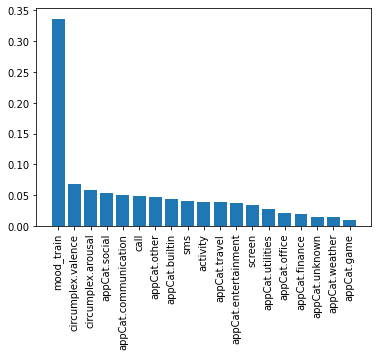

In [ ]:
zipper = sorted([i for i in zip(regr.feature_importances_,[i for i in MLP_df[colls].columns])],key= lambda x: x[0],reverse=True)

x = [i[1] for i in zipper]
height = [float(i[0]) for i in zipper]
x_pos = [i for i, _ in enumerate(x)]


plt.bar(x, height)
plt.xticks(rotation=90)
plt.show( )

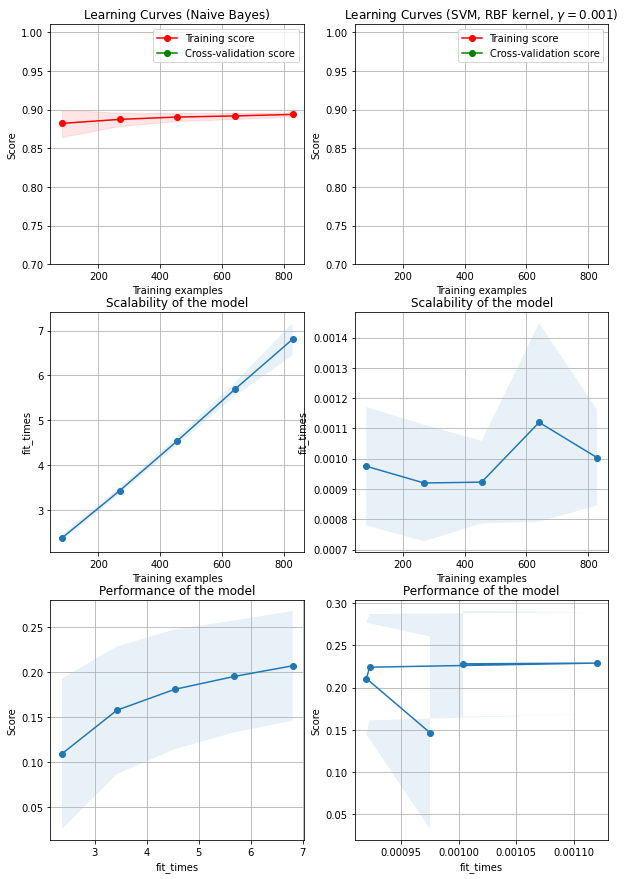

In [ ]:
# import matplotlib.pyplot as plt

# from sklearn.model_selection import learning_curve

# loss_values = learning_curve(regr, X, y)
# plt.plot(loss_values)
# plt.show()



import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

# X, y = load_digits(return_X_y=True)

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plot_learning_curve(regr, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = LinearRegression()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()